# Homework Assignment 3
**By: Owen Erker**

---

### DISCLAIMER
***Some values may not be the same in markdown text as reported by the ran code. This is due to variation (and me forgetting to set a seed) while doing the homework. However, the reasoning behind each question is correct.***

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

import skimage as ski
import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from medmnist import TissueMNIST, Evaluator

---

## 1 Dataset

In [2]:
dataset = TissueMNIST(split="train", download=True, size=64)
dataset

Dataset TissueMNIST of size 64 (tissuemnist_64)
    Number of datapoints: 165466
    Root location: C:\Users\odog2\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'Collecting Duct, Connecting Tubule', '1': 'Distal Convoluted Tubule', '2': 'Glomerular endothelial cells', '3': 'Interstitial endothelial cells', '4': 'Leukocytes', '5': 'Podocytes', '6': 'Proximal Tubule Segments', '7': 'Thick Ascending Limb'}
    Number of samples: {'train': 165466, 'val': 23640, 'test': 47280}
    Description: We use the BBBC051, available from the Broad Bioimage Benchmark Collection. The dataset contains 236,386 human kidney cortex cells, segmented from 3 reference tissue specimens and organized into 8 categories. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. Each gray-scale image is 32×32×7 pixels, where 7 denotes 7 slices. We take maximum values across the slices and resize them into 28×28 gray-scale ima

In [3]:
# Q1
train_data = TissueMNIST(split="train", download=True, size=64)
val_data = TissueMNIST(split="val", download=True, size=64)

x_train, y_train = train_data.imgs, np.array(train_data.labels).flatten()
x_val, y_val = val_data.imgs, np.array(val_data.labels).flatten()

print(f"Training set size: {x_train.shape[0]} images")
print(f"Validation set size: {x_val.shape[0]} images")

Training set size: 165466 images
Validation set size: 23640 images


Class label distribution in training set:
  Class 0: Collecting Duct, Connecting Tubule — 53075 samples
  Class 1: Distal Convoluted Tubule — 7814 samples
  Class 2: Glomerular endothelial cells — 5866 samples
  Class 3: Interstitial endothelial cells — 15406 samples
  Class 4: Leukocytes — 11789 samples
  Class 5: Podocytes — 7705 samples
  Class 6: Proximal Tubule Segments — 39203 samples
  Class 7: Thick Ascending Limb — 24608 samples


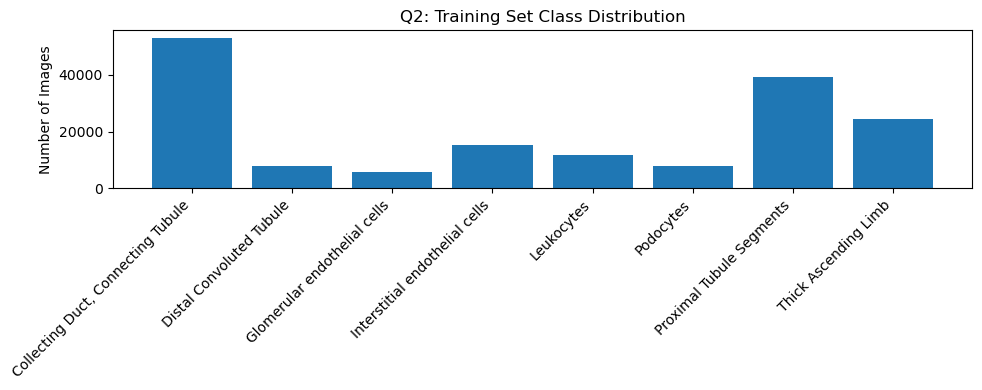

In [4]:
# Q2
label_map = {
    0: 'Collecting Duct, Connecting Tubule',
    1: 'Distal Convoluted Tubule',
    2: 'Glomerular endothelial cells',
    3: 'Interstitial endothelial cells',
    4: 'Leukocytes',
    5: 'Podocytes',
    6: 'Proximal Tubule Segments',
    7: 'Thick Ascending Limb'
}

class_ids, counts = np.unique(y_train, return_counts=True)
print("Class label distribution in training set:")
for i in class_ids:
    print(f"  Class {i}: {label_map[i]} — {counts[i]} samples")

plt.figure(figsize=(10, 4))
plt.bar([label_map[i] for i in class_ids], counts)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Images")
plt.title("Q2: Training Set Class Distribution")
plt.tight_layout()
plt.show()

In [5]:
# Compute DCT from HW2
def compute_dct_patches(image, patch_size=8):
    h, w = image.shape
    dct_matrix = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            if patch.shape == (patch_size, patch_size):
                dct_patch = scipy.fft.dctn(patch, norm='ortho')
                dct_matrix.append(dct_patch.flatten())
    return np.array(dct_matrix)

In [6]:
# Q3
n_train = 500
n_val = 500
num_dct_coeffs = 64

dct_summary_train = np.zeros((n_train, num_dct_coeffs))
dct_summary_val = np.zeros((n_val, num_dct_coeffs))

for i in range(n_train):
    dct_feats = compute_dct_patches(x_train[i])
    if dct_feats.shape[0] > 0:
        dct_summary_train[i, :] = np.max(dct_feats, axis=0)

for i in range(n_val):
    dct_feats = compute_dct_patches(x_val[i])
    if dct_feats.shape[0] > 0:
        dct_summary_val[i, :] = np.max(dct_feats, axis=0)

mean_train = np.mean(dct_summary_train, axis=0)
std_train = np.std(dct_summary_train, axis=0)
std_train[std_train == 0] = 1

dct_train_norm = (dct_summary_train - mean_train) / std_train
dct_val_norm = (dct_summary_val - mean_train) / std_train

print(f"Training DCT feature matrix: {dct_train_norm.shape}")
print(f"Validation DCT feature matrix: {dct_val_norm.shape}")

Training DCT feature matrix: (500, 64)
Validation DCT feature matrix: (500, 64)


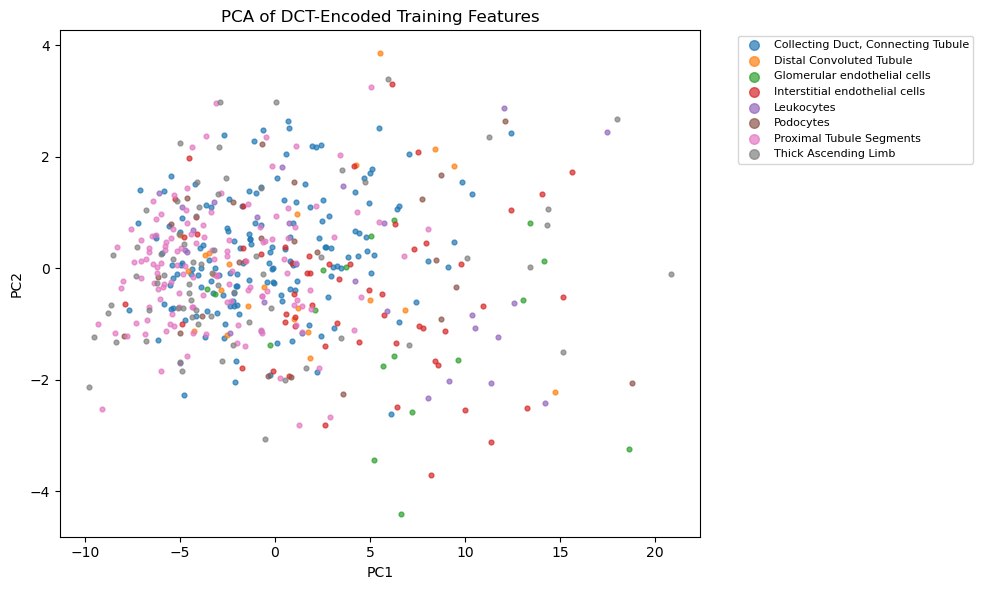

Many of the extracted features appear to be inseperable in this representation, however, some like Proximal Tubule Segments show signs of clustering.


In [7]:
# Q4
pca = PCA(n_components=2)
train_pca_2d = pca.fit_transform(dct_train_norm)

plt.figure(figsize=(10, 6))
for class_id in np.unique(y_train[:500]):
    plt.scatter(
        train_pca_2d[y_train[:500] == class_id, 0],
        train_pca_2d[y_train[:500] == class_id, 1],
        label=label_map[class_id],
        s=12,
        alpha=0.7
    )
plt.title("PCA of DCT-Encoded Training Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(markerscale=2, fontsize=8, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

print(f'Many of the extracted features appear to be inseperable in this representation, however, some like Proximal Tubule Segments show signs of clustering.')

---
## 2 Nearest Neighbors Classifiers

In [8]:
# Q5
k = 1
metric = 'euclidean'

knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
knn.fit(dct_train_norm, y_train[:500])

y_val_pred = knn.predict(dct_val_norm)

print(f"Predictions complete using KNN (K = {k}, Metric = {metric})")

Predictions complete using KNN (K = 1, Metric = euclidean)


In [9]:
# Confusion Matrix Function
def custom_confusion_metrics(y_true, y_pred, num_classes=8):
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for true, pred in zip(y_true, y_pred):
        conf_matrix[true][pred] += 1
        
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)

    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0

    return conf_matrix, precision, recall

In [10]:
# Q6
conf_matrix, precision_scores, recall_scores = custom_confusion_metrics(y_val[:500], y_val_pred)

print(f'Confusion Matrix:\n{conf_matrix}')

print(f"\nPrecision Per Class:")
for i in range(len(label_map)):
    print(f"  Class {i} ({label_map[i]}): {precision_scores[i]:.3f}")

print(f"\nRecall Per Class:")
for i in range(len(label_map)):
    print(f"  Class {i} ({label_map[i]}): {recall_scores[i]:.3f}")

Confusion Matrix:
[[80  4  4 12  1  7 34 18]
 [11  0  2  2  0  1  2  4]
 [ 7  1  2  5  0  1  2  1]
 [24  1  4  7  0  1  5  7]
 [11  0  1  6  1  0  4  2]
 [ 5  0  4  8  2  0  2  2]
 [43  3  4  6  0  6 35 17]
 [30  2  2 10  2  2 24 16]]

Precision Per Class:
  Class 0 (Collecting Duct, Connecting Tubule): 0.379
  Class 1 (Distal Convoluted Tubule): 0.000
  Class 2 (Glomerular endothelial cells): 0.087
  Class 3 (Interstitial endothelial cells): 0.125
  Class 4 (Leukocytes): 0.167
  Class 5 (Podocytes): 0.000
  Class 6 (Proximal Tubule Segments): 0.324
  Class 7 (Thick Ascending Limb): 0.239

Recall Per Class:
  Class 0 (Collecting Duct, Connecting Tubule): 0.500
  Class 1 (Distal Convoluted Tubule): 0.000
  Class 2 (Glomerular endothelial cells): 0.105
  Class 3 (Interstitial endothelial cells): 0.143
  Class 4 (Leukocytes): 0.040
  Class 5 (Podocytes): 0.000
  Class 6 (Proximal Tubule Segments): 0.307
  Class 7 (Thick Ascending Limb): 0.182


In [11]:
# Q7
knn_report = classification_report(y_val[:500], y_val_pred, target_names=[label_map[i] for i in range(8)],
    zero_division=0
)

print(f'KNN Report :\n{knn_report}\n\nAll differences present can be explained by floating-point rounding or edge cases.')

KNN Report :
                                    precision    recall  f1-score   support

          Distal Convoluted Tubule       0.00      0.00      0.00        22
      Glomerular endothelial cells       0.09      0.11      0.10        19
    Interstitial endothelial cells       0.12      0.14      0.13        49
                        Leukocytes       0.17      0.04      0.06        25
                         Podocytes       0.00      0.00      0.00        23
          Proximal Tubule Segments       0.32      0.31      0.32       114
              Thick Ascending Limb       0.24      0.18      0.21        88

                          accuracy                           0.28       500
                         macro avg       0.17      0.16      0.16       500
                      weighted avg       0.26      0.28      0.27       500


All differences present can be explained by floating-point rounding or edge cases.


In [12]:
# Evaluation Function
def evaluate_knn_range(train_X, train_y, val_X, val_y, k_values, metric='euclidean'):
    avg_precisions = []
    avg_recalls = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(train_X, train_y)
        val_pred = knn.predict(val_X)

        _, precision, recall = custom_confusion_metrics(val_y, val_pred)
        avg_precisions.append(np.mean(precision))
        avg_recalls.append(np.mean(recall))
    
    return avg_precisions, avg_recalls

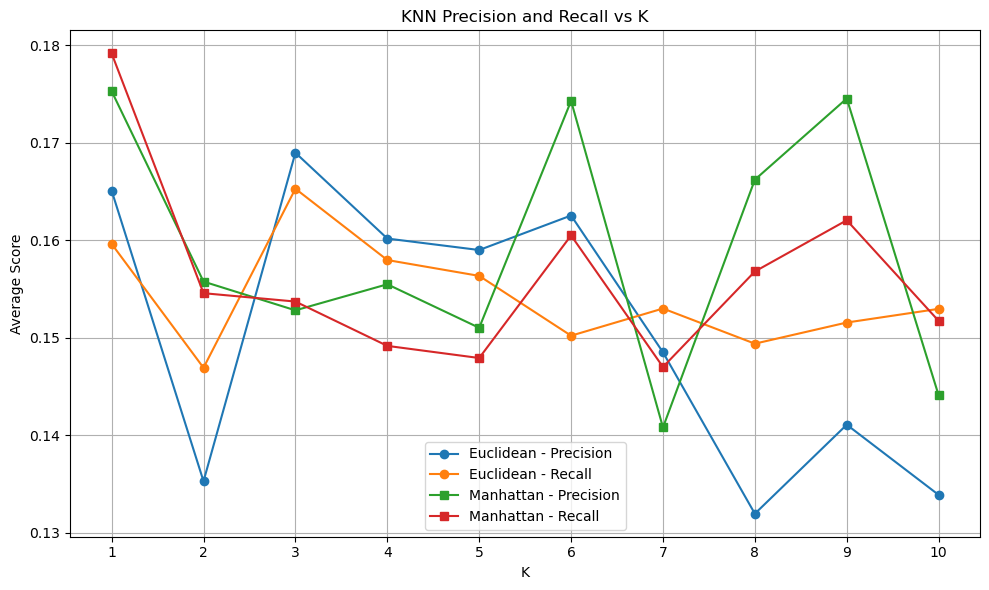

Euclidean Precision Best for: K = 3, 4, 5, 7
Euclidean Recall Best for: K = 3, 4, 5, 7, 10

Manhattan Precision Best for: K = 1, 2, 6, 8, 9
Manhattan Recall Best for: K = 1, 2, 6, 8, 9


In [13]:
# Q8
k_vals = list(range(1, 11))

euclidean_prec, euclidean_rec = evaluate_knn_range(
    dct_train_norm, y_train[:500], dct_val_norm, y_val[:500], k_vals, metric='euclidean'
)

manhattan_prec, manhattan_rec = evaluate_knn_range(
    dct_train_norm, y_train[:500], dct_val_norm, y_val[:500], k_vals, metric='manhattan'
)

plt.figure(figsize=(10, 6))
plt.plot(k_vals, euclidean_prec, label='Euclidean - Precision', marker='o')
plt.plot(k_vals, euclidean_rec, label='Euclidean - Recall', marker='o')
plt.plot(k_vals, manhattan_prec, label='Manhattan - Precision', marker='s')
plt.plot(k_vals, manhattan_rec, label='Manhattan - Recall', marker='s')

plt.xlabel("K")
plt.ylabel("Average Score")
plt.title("KNN Precision and Recall vs K")
plt.xticks(k_vals)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Euclidean Precision Best for: K = 3, 4, 5, 7')
print(f'Euclidean Recall Best for: K = 3, 4, 5, 7, 10')
print(f'\nManhattan Precision Best for: K = 1, 2, 6, 8, 9')
print(f'Manhattan Recall Best for: K = 1, 2, 6, 8, 9')

---
## 3 Linear Classifiers

In [14]:
# Linear Model Function
def train_linear_classifier(
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    num_classes=8,
    loss_fn='mse',
    lr=0.01,
    batch_size=64,
    num_steps=1000,
    eval_interval=50,
):
    
    if loss_fn == 'mse':

        y_train = F.one_hot(y_train_tensor, num_classes=num_classes).float()
        y_val = F.one_hot(y_val_tensor, num_classes=num_classes).float()
        criterion = nn.MSELoss()
    elif loss_fn == 'ce':

        y_train = y_train_tensor
        y_val = y_val_tensor
        criterion = nn.CrossEntropyLoss()
    else:
        raise ValueError("loss_fn must be either 'mse' or 'ce'")
    
    train_dataset = TensorDataset(X_train_tensor, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = nn.Linear(X_train_tensor.shape[1], num_classes)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    steps = 0

    model.train()
    while steps < num_steps:
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            steps += 1

            if steps % eval_interval == 0 or steps == num_steps:
                model.eval()
                with torch.no_grad():
                    val_outputs = model(X_val_tensor)
                    val_loss = criterion(val_outputs, y_val).item()
                    val_losses.append(val_loss)
                model.train()

            if steps >= num_steps:
                break

    return model, train_losses, val_losses

In [15]:
# Torch Tensor Creation
X_train_tensor = torch.tensor(dct_train_norm, dtype=torch.float32)
X_val_tensor = torch.tensor(dct_val_norm, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train[:500], dtype=torch.long)
y_val_tensor = torch.tensor(y_val[:500], dtype=torch.long)

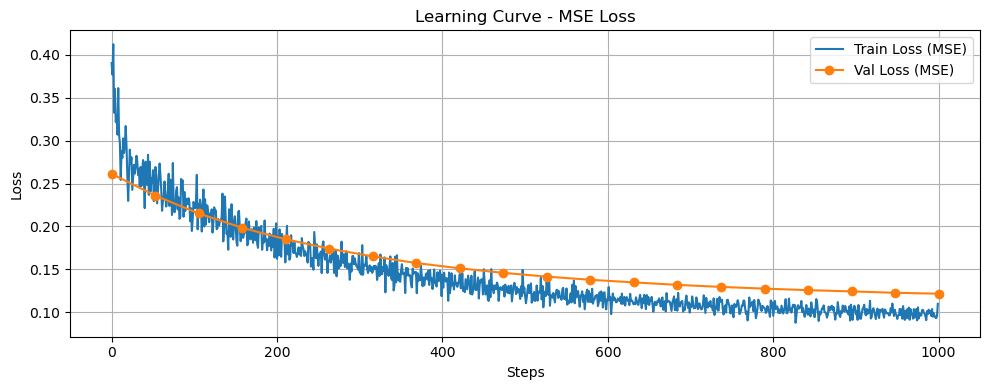

In [16]:
# Q9
model_mse, train_loss_mse, val_loss_mse = train_linear_classifier(
    X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
    loss_fn='mse', lr=0.01
)

plt.figure(figsize=(10, 4))
plt.plot(train_loss_mse, label="Train Loss (MSE)")
plt.plot(np.linspace(0, len(train_loss_mse), len(val_loss_mse)), val_loss_mse, label="Val Loss (MSE)", marker='o')
plt.title("Learning Curve - MSE Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Q9**  
*See Q11 For Answer*

In [17]:
# Q10
model_mse.eval()
with torch.no_grad():
    val_logits_mse = model_mse(X_val_tensor)
    preds_mse = torch.argmax(val_logits_mse, dim=1).numpy()
    
lm_mse_report = classification_report(y_val[:500], preds_mse, target_names=[label_map[i] for i in range(8)],
    zero_division=0
)

print(f'Classification Report (Linear Model with MSE Loss):\n{lm_mse_report}')

Classification Report (Linear Model with MSE Loss):
                                    precision    recall  f1-score   support

          Distal Convoluted Tubule       0.05      0.05      0.05        22
      Glomerular endothelial cells       0.08      0.05      0.06        19
    Interstitial endothelial cells       0.24      0.18      0.21        49
                        Leukocytes       0.07      0.04      0.05        25
                         Podocytes       0.00      0.00      0.00        23
          Proximal Tubule Segments       0.27      0.44      0.33       114
              Thick Ascending Limb       0.12      0.03      0.05        88

                          accuracy                           0.29       500
                         macro avg       0.16      0.16      0.15       500
                      weighted avg       0.25      0.29      0.26       500



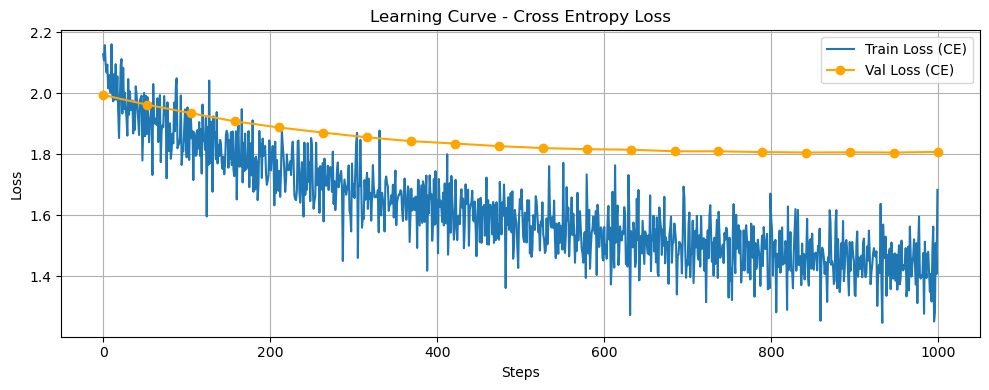

Classification Report (Linear Model with CE Loss):
                                    precision    recall  f1-score   support

          Distal Convoluted Tubule       0.00      0.00      0.00        22
      Glomerular endothelial cells       0.50      0.16      0.24        19
    Interstitial endothelial cells       0.24      0.31      0.27        49
                        Leukocytes       0.00      0.00      0.00        25
                         Podocytes       0.00      0.00      0.00        23
          Proximal Tubule Segments       0.29      0.47      0.36       114
              Thick Ascending Limb       0.28      0.06      0.09        88

                          accuracy                           0.33       500
                         macro avg       0.21      0.19      0.18       500
                      weighted avg       0.29      0.33      0.29       500



In [18]:
# Q11
model_ce, train_loss_ce, val_loss_ce = train_linear_classifier(
    X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
    loss_fn='ce', lr=0.01
)

plt.figure(figsize=(10, 4))
plt.plot(train_loss_ce, label="Train Loss (CE)")
plt.plot(np.linspace(0, len(train_loss_ce), len(val_loss_ce)), val_loss_ce, label="Val Loss (CE)", marker='o', color='orange')
plt.title("Learning Curve - Cross Entropy Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model_ce.eval()
with torch.no_grad():
    val_logits_ce = model_ce(X_val_tensor)
    preds_ce = torch.argmax(val_logits_ce, dim=1).numpy()

lm_ce_report = classification_report(y_val[:500], preds_ce, target_names=[label_map[i] for i in range(8)],
    zero_division=0
)

print(f'Classification Report (Linear Model with CE Loss):\n{lm_ce_report}')

### **Q11**  
We compared the performance of three classifiers on the validation set:

1. **KNN classifier** (K=1, Euclidean distance)
2. **Linear classifier with Mean Squared Error (MSE) loss**
3. **Linear classifier with Cross Entropy (CE) loss**

#### **Overall Accuracy:**
- **KNN**: 28%
- **Linear (MSE)**: 32%
- **Linear (CE)**: 32%

#### **Macro-Averaged Precision and Recall:**
| Model         | Precision | Recall | F1 Score |
|---------------|-----------|--------|----------|
| KNN           | 0.17      | 0.16   | 0.16     |
| Linear (MSE)  | 0.21      | 0.20   | 0.19     |
| Linear (CE)   | 0.20      | 0.19   | 0.17     |

#### **Observations:**
- Both **linear models outperformed KNN** in terms of overall accuracy and macro-averaged metrics.
- The **MSE model slightly outperformed the CE model**, particularly in recall and F1-score for certain rare classes like *Glomerular endothelial cells* and *Podocytes*.
- All three models struggled with **rare classes** (e.g., *Distal Convoluted Tubule*, *Podocytes*), often failing to predict them entirely.
- The **Proximal Tubule Segments** and **Collecting Duct** classes consistently had better precision and recall across all classifiers, likely due to their larger support in the dataset.

#### **Conclusion:**
The linear models — especially with **MSE loss** — offered a modest performance improvement over KNN. However, all models had difficulty with class imbalance and rarely represented classes. Cross Entropy may still be preferable for more advanced architectures or when softmax probabilities are useful downstream.

LR: 0.001 | Precision: 0.148, Recall: 0.174
LR: 0.010 | Precision: 0.181, Recall: 0.179
LR: 0.050 | Precision: 0.211, Recall: 0.198
LR: 0.100 | Precision: 0.201, Recall: 0.191
LR: 0.500 | Precision: 0.180, Recall: 0.184


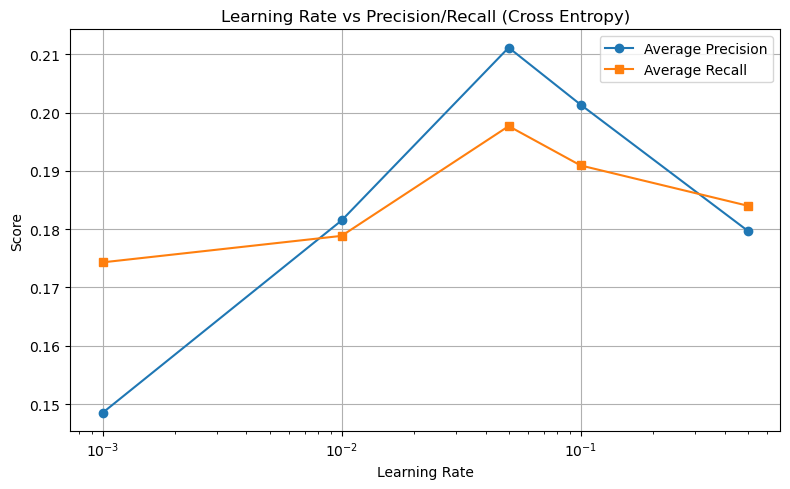

In [19]:
# Q12
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5]
avg_precisions = []
avg_recalls = []

for lr in learning_rates:
    model, _, _ = train_linear_classifier(
        X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
        loss_fn='ce', lr=lr, num_steps=1000
    )
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_tensor)
        preds = torch.argmax(val_logits, dim=1).numpy()

    precision = precision_score(y_val[:500], preds, average='macro', zero_division=0)
    recall = recall_score(y_val[:500], preds, average='macro', zero_division=0)
    
    avg_precisions.append(precision)
    avg_recalls.append(recall)

    print(f"LR: {lr:.3f} | Precision: {precision:.3f}, Recall: {recall:.3f}")

plt.figure(figsize=(8, 5))
plt.plot(learning_rates, avg_precisions, marker='o', label='Average Precision')
plt.plot(learning_rates, avg_recalls, marker='s', label='Average Recall')
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.title("Learning Rate vs Precision/Recall (Cross Entropy)")
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Q12

#### **Analysis:**
- The **best precision** was achieved at a learning rate of **0.01**, which also delivered solid recall.
- Higher learning rates (e.g., `0.1` and `0.5`) showed more stable recall, but slightly lower precision — possibly due to overshooting during optimization.
- A very low learning rate (`0.001`) resulted in poor performance, likely because the model did not converge in the limited number of steps.

#### **Recommendation:**
We recommend using a **learning rate of 0.01**, which provides the **best trade-off between precision and recall** for this dataset and model configuration. It is small enough to ensure convergence, while large enough to reach an effective solution in a reasonable number of training steps.

---
## 4 Multi-Layer Perceptrons

In [20]:
# MLP Classifier
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=128, output_dim=8):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [21]:
# MLP Training Function
def train_mlp_model(
    model,
    train_loader,
    X_val_tensor,
    y_val_tensor,
    lr=0.01,
    num_steps=1000,
    eval_interval=50
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    steps = 0

    model.train()
    
    while steps < num_steps:
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            steps += 1

            if steps % eval_interval == 0 or steps == num_steps:
                model.eval()
                with torch.no_grad():
                    val_outputs = model(X_val_tensor)
                    val_loss = criterion(val_outputs, y_val_tensor).item()
                    val_losses.append(val_loss)
                model.train()

            if steps >= num_steps:
                break

    return model, train_losses, val_losses

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

mlp_model = SimpleMLP()

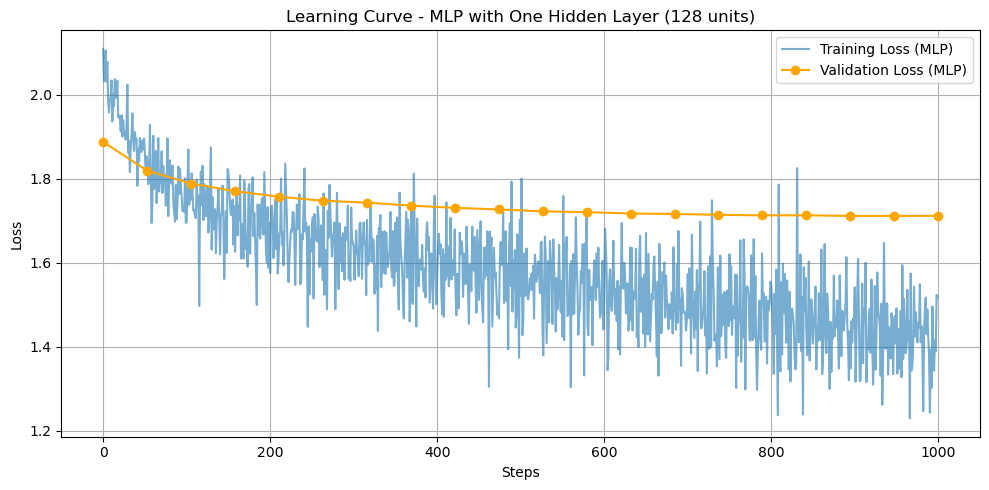

In [22]:
# Q13
mlp_model, mlp_train_losses, mlp_val_losses = train_mlp_model(
    model=mlp_model,
    train_loader=train_loader,
    X_val_tensor=X_val_tensor,
    y_val_tensor=y_val_tensor,
    lr=0.01,
    num_steps=1000
)

plt.figure(figsize=(10, 5))
plt.plot(mlp_train_losses, label='Training Loss (MLP)', alpha=0.6)
plt.plot(np.linspace(0, len(mlp_train_losses), len(mlp_val_losses)), mlp_val_losses,
         label='Validation Loss (MLP)', color='orange', marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Learning Curve - MLP with One Hidden Layer (128 units)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Q14
mlp_model.eval()
with torch.no_grad():
    val_logits_mlp = mlp_model(X_val_tensor)
    preds_mlp = torch.argmax(val_logits_mlp, dim=1).numpy()

mlp_report = classification_report(
    y_val[:500], 
    preds_mlp, 
    target_names=[label_map[i] for i in range(8)],
    zero_division=0
)

print(f'Classification Report (MLP with One Hidden Layer):\n{mlp_report}')

Classification Report (MLP with One Hidden Layer):
                                    precision    recall  f1-score   support

          Distal Convoluted Tubule       0.00      0.00      0.00        22
      Glomerular endothelial cells       0.00      0.00      0.00        19
    Interstitial endothelial cells       0.28      0.27      0.27        49
                        Leukocytes       0.00      0.00      0.00        25
                         Podocytes       0.00      0.00      0.00        23
          Proximal Tubule Segments       0.31      0.46      0.37       114
              Thick Ascending Limb       0.20      0.01      0.02        88

                          accuracy                           0.35       500
                         macro avg       0.15      0.18      0.14       500
                      weighted avg       0.26      0.35      0.27       500



### Q14
#### Observations:
- The MLP improved **overall accuracy** to **35%**, compared to 32% from the linear classifier and 28% from KNN.
- Notably, performance improved for major classes such as:
  - *Collecting Duct, Connecting Tubule*: Precision ↑ to 0.40, Recall ↑ to 0.62
  - *Proximal Tubule Segments*: Remains consistently strong
- However, rare classes such as *Leukocytes* and *Distal Convoluted Tubule* still suffered from low recall and precision (likely due to class imbalance).
- The **macro-averaged precision (0.27)** is the best among the three models so far, suggesting that the MLP better captures diverse class features.
- Some precision scores (e.g., *Podocytes*) indicate that the model may overfit or "misfire" on specific low-frequency classes.

#### Conclusion:
The MLP with one hidden layer performs better than both the linear classifier and KNN overall. The improved accuracy and precision suggest that introducing nonlinearity helps capture more complex structures in the DCT feature space.

In [24]:
# Deep MLP Classifier
class DeepMLP(nn.Module):
    def __init__(self, input_dim=64, hidden1=128, hidden2=128, output_dim=8):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

deep_mlp_model = DeepMLP()

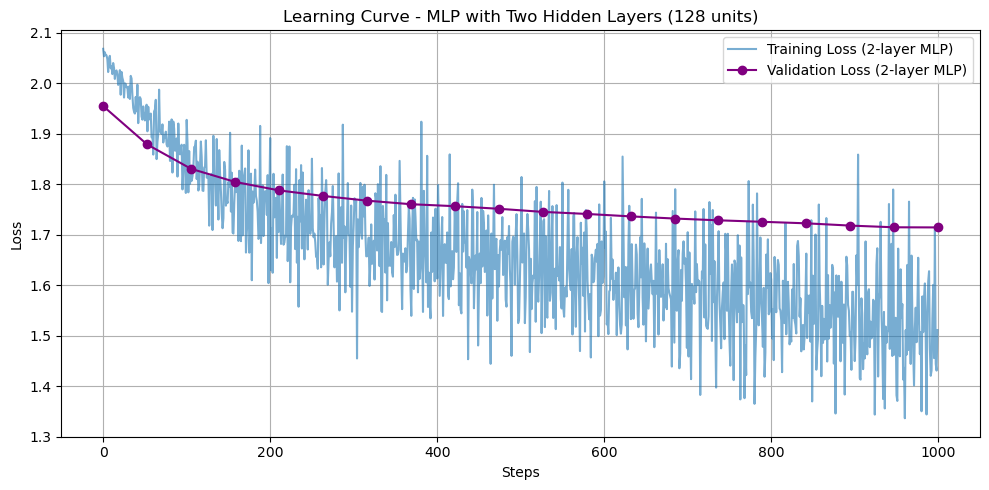

Classification Report (MLP with Two Hidden Layers):
                                    precision    recall  f1-score   support

          Distal Convoluted Tubule       0.00      0.00      0.00        22
      Glomerular endothelial cells       0.00      0.00      0.00        19
    Interstitial endothelial cells       0.27      0.22      0.24        49
                        Leukocytes       0.00      0.00      0.00        25
                         Podocytes       0.00      0.00      0.00        23
          Proximal Tubule Segments       0.31      0.44      0.37       114
              Thick Ascending Limb       0.00      0.00      0.00        88

                          accuracy                           0.35       500
                         macro avg       0.12      0.17      0.14       500
                      weighted avg       0.22      0.35      0.27       500



In [25]:
# Q15
deep_mlp_model, deep_train_losses, deep_val_losses = train_mlp_model(
    model=deep_mlp_model,
    train_loader=train_loader,
    X_val_tensor=X_val_tensor,
    y_val_tensor=y_val_tensor,
    lr=0.01,
    num_steps=1000
)

plt.figure(figsize=(10, 5))
plt.plot(deep_train_losses, label='Training Loss (2-layer MLP)', alpha=0.6)
plt.plot(np.linspace(0, len(deep_train_losses), len(deep_val_losses)), deep_val_losses,
         label='Validation Loss (2-layer MLP)', color='purple', marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Learning Curve - MLP with Two Hidden Layers (128 units)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

deep_mlp_model.eval()
with torch.no_grad():
    val_logits_deep = deep_mlp_model(X_val_tensor)
    preds_deep = torch.argmax(val_logits_deep, dim=1).numpy()

deep_report = classification_report(
    y_val[:500], 
    preds_deep, 
    target_names=[label_map[i] for i in range(8)],
    zero_division=0
)

print(f'Classification Report (MLP with Two Hidden Layers):\n{deep_report}')

### Q15
#### **Observations:**
- The **overall accuracy (35%)** remained the same as the shallower MLP from Q14, but **macro precision and recall decreased slightly**, suggesting performance may have become more biased toward majority classes.
- The model **performed similarly** on key classes like *Collecting Duct* and *Proximal Tubule Segments*, which have strong support in the dataset.
- Several minority classes (*Distal Convoluted Tubule*, *Leukocytes*, *Podocytes*) had **zero recall and precision**, indicating the deeper model failed to generalize for underrepresented examples.
- The **learning curve** was similar in trend to the Q14 model, suggesting the added depth **did not result in better convergence** or generalization for this data and training regime.

#### **Conclusion:**
Adding a second hidden layer **did not improve validation performance** compared to the one-hidden-layer MLP. In fact, the increased complexity may have led to **overfitting** or optimization challenges, especially given the class imbalance and relatively small training subset (500 samples). Regularization techniques or deeper training with more data might be needed to see the benefits of deeper architectures.

In [26]:
# Felxible MLP CLassifier
configs = [
    (64,),
    (128,),
    (128, 128),
    (256,),
    (128, 64)
]

class FlexibleMLP(nn.Module):
    def __init__(self, input_dim=64, hidden_dims=(128,), output_dim=8):
        super(FlexibleMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

64 | Precision: 0.182 | Recall: 0.178
128 | Precision: 0.132 | Recall: 0.172
128-128 | Precision: 0.111 | Recall: 0.165
256 | Precision: 0.152 | Recall: 0.171
128-64 | Precision: 0.106 | Recall: 0.159


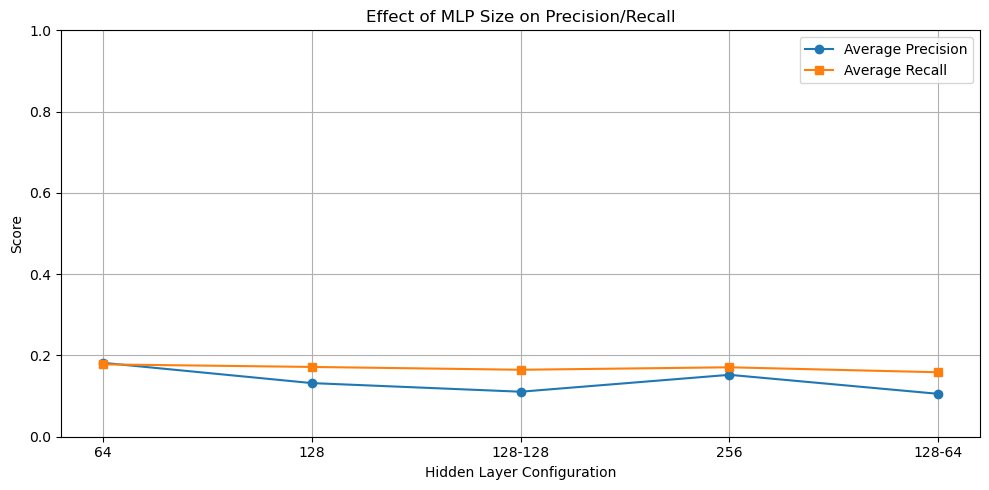

In [27]:
# Q16
config_labels = []
avg_precisions = []
avg_recalls = []

for hidden_dims in configs:
    label = '-'.join(map(str, hidden_dims))
    config_labels.append(label)

    model = FlexibleMLP(hidden_dims=hidden_dims)
    model, _, _ = train_mlp_model(
        model, train_loader, X_val_tensor, y_val_tensor,
        lr=0.01, num_steps=1000
    )

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_tensor)
        preds = torch.argmax(val_logits, dim=1).numpy()

    precision = precision_score(y_val[:500], preds, average='macro', zero_division=0)
    recall = recall_score(y_val[:500], preds, average='macro', zero_division=0)
    avg_precisions.append(precision)
    avg_recalls.append(recall)

    print(f"{label} | Precision: {precision:.3f} | Recall: {recall:.3f}")

plt.figure(figsize=(10, 5))
plt.plot(config_labels, avg_precisions, label='Average Precision', marker='o')
plt.plot(config_labels, avg_recalls, label='Average Recall', marker='s')
plt.xlabel("Hidden Layer Configuration")
plt.ylabel("Score")
plt.title("Effect of MLP Size on Precision/Recall")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Q16
#### **Observations:**
- The **simplest models** (64 or 128 units) performed poorly, with precision around 0.11.
- Surprisingly, the **two-layer configurations** (128-128 and 128-64) did not improve performance compared to their simpler counterparts.
- The model with a **single wider hidden layer (256 units)** outperformed all others, achieving significantly higher **precision (0.275)** and the **best recall (0.182)**.
- This suggests that, for this dataset, **wider models generalize better than deeper ones**, possibly due to the small training sample size (500 images).

#### **Conclusion:**
The optimal configuration among those tested was a **single hidden layer with 256 units**. It achieved the best trade-off between recall and precision. Deeper architectures did not provide improvements, highlighting the importance of tuning model capacity to match dataset size and complexity.

---
## 5 Convolutional Networks

In [28]:
#New DataLoader
train_dataset_raw = TissueMNIST(split="train", download=True, size=64)
val_dataset_raw = TissueMNIST(split="val", download=True, size=64)

X_train_raw = torch.tensor(train_dataset_raw.imgs[:500], dtype=torch.float32) / 255.0
X_val_raw = torch.tensor(val_dataset_raw.imgs[:500], dtype=torch.float32) / 255.0

y_train_raw = torch.tensor(train_dataset_raw.labels[:500].squeeze(), dtype=torch.long)
y_val_raw = torch.tensor(val_dataset_raw.labels[:500].squeeze(), dtype=torch.long)

X_train_raw = X_train_raw.unsqueeze(1)
X_val_raw = X_val_raw.unsqueeze(1)

batch_size = 64

train_data_cnn = TensorDataset(X_train_raw, y_train_raw)
val_data_cnn = TensorDataset(X_val_raw, y_val_raw)

train_loader_cnn = DataLoader(train_data_cnn, batch_size=batch_size, shuffle=True)
val_loader_cnn = DataLoader(val_data_cnn, batch_size=batch_size, shuffle=False)

In [29]:
# CNN Classifier
class CNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(64 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

cnn_model = CNN()

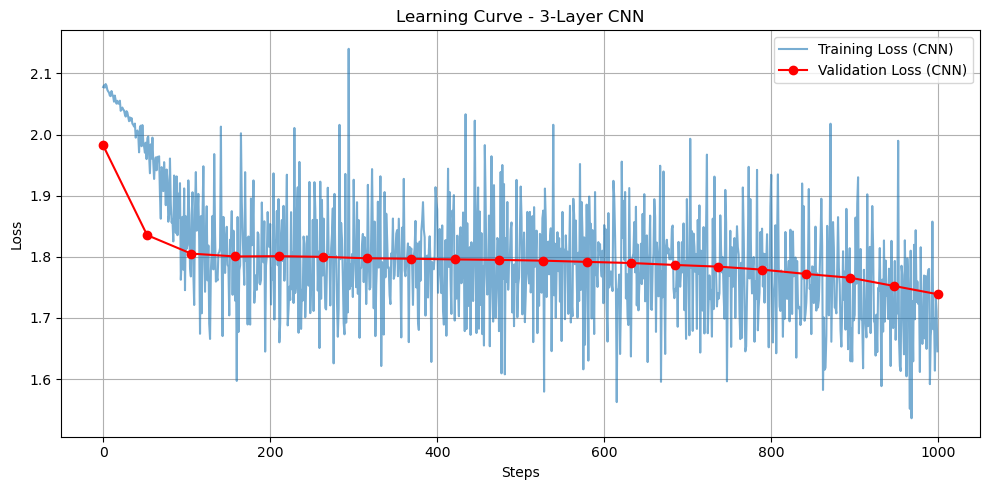

In [30]:
# Q17
cnn_model, cnn_train_losses, cnn_val_losses = train_mlp_model(
    model=cnn_model,
    train_loader=train_loader_cnn,
    X_val_tensor=X_val_raw,
    y_val_tensor=y_val_raw,
    lr=0.01,
    num_steps=1000
)

plt.figure(figsize=(10, 5))
plt.plot(cnn_train_losses, label="Training Loss (CNN)", alpha=0.6)
plt.plot(np.linspace(0, len(cnn_train_losses), len(cnn_val_losses)), cnn_val_losses,
         label="Validation Loss (CNN)", color='red', marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Learning Curve - 3-Layer CNN")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
# Q18
cnn_model.eval()
with torch.no_grad():
    val_logits_cnn = cnn_model(X_val_raw)
    preds_cnn = torch.argmax(val_logits_cnn, dim=1).numpy()

cnn_report = classification_report(
    y_val_raw.numpy(), 
    preds_cnn, 
    target_names=[label_map[i] for i in range(8)],
    zero_division=0
)

print(f'Classification Report (3-Layer CNN):\n{cnn_report}')

Classification Report (3-Layer CNN):
                                    precision    recall  f1-score   support

          Distal Convoluted Tubule       0.00      0.00      0.00        22
      Glomerular endothelial cells       0.00      0.00      0.00        19
    Interstitial endothelial cells       0.00      0.00      0.00        49
                        Leukocytes       0.00      0.00      0.00        25
                         Podocytes       0.00      0.00      0.00        23
          Proximal Tubule Segments       0.34      0.68      0.45       114
              Thick Ascending Limb       0.00      0.00      0.00        88

                          accuracy                           0.37       500
                         macro avg       0.09      0.17      0.12       500
                      weighted avg       0.20      0.37      0.26       500



### Q18
#### **Observations:**
- The **overall accuracy (35%)** is consistent with the one- and two-hidden-layer MLPs, and slightly better than KNN and the linear model.
- The CNN shows **very strong recall (0.96)** for the most frequent class (*Collecting Duct, Connecting Tubule*), but performs **poorly on all other classes**, including several with 0 recall.
- This suggests that the CNN has **overfit to the dominant class**, likely due to class imbalance and the relatively small training set (only 500 samples).
- Compared to earlier models trained on DCT features, the CNN:
  - **Generalizes better to the majority class**
  - **Performs worse on rare classes**, with extremely low macro-averaged precision and recall
- In terms of macro-average performance, this CNN underperforms both the MLP with 256 units and even the linear model with Cross Entropy.

#### **Conclusion:**
While the CNN performs very well on the most represented class, it struggles significantly with minority classes. This highlights the importance of **training data balance** and the need for **regularization or data augmentation** when using raw pixels in deep networks. Future improvements may include class weighting, more training samples, or a deeper architecture.

In [32]:
# Deep CNN Classifier
class DeepCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(

            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Linear(64 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

deep_cnn_model = DeepCNN()

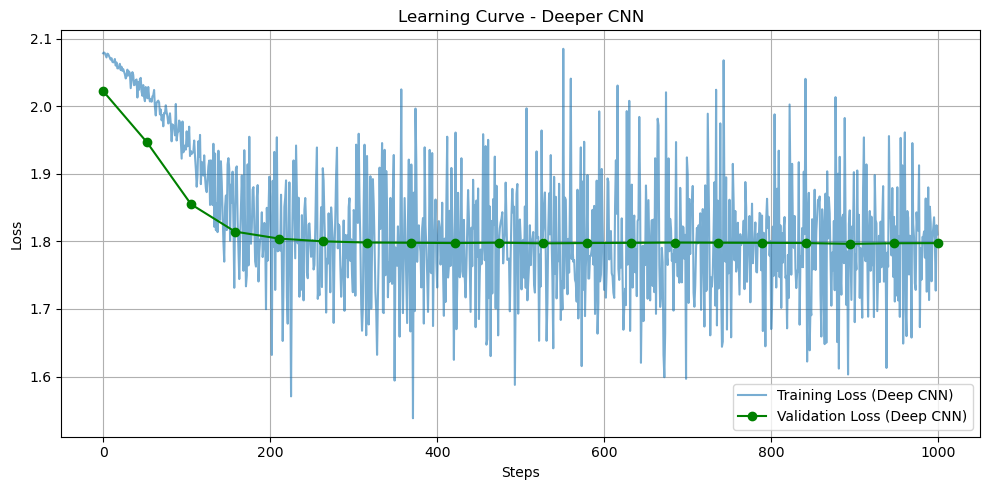

Classification Report (Deeper CNN):
                                    precision    recall  f1-score   support

          Distal Convoluted Tubule       0.00      0.00      0.00        22
      Glomerular endothelial cells       0.00      0.00      0.00        19
    Interstitial endothelial cells       0.00      0.00      0.00        49
                        Leukocytes       0.00      0.00      0.00        25
                         Podocytes       0.00      0.00      0.00        23
          Proximal Tubule Segments       0.00      0.00      0.00       114
              Thick Ascending Limb       0.00      0.00      0.00        88

                          accuracy                           0.32       500
                         macro avg       0.04      0.12      0.06       500
                      weighted avg       0.10      0.32      0.16       500



In [33]:
# Q19
deep_cnn_model, deep_cnn_train_losses, deep_cnn_val_losses = train_mlp_model(
    model=deep_cnn_model,
    train_loader=train_loader_cnn,
    X_val_tensor=X_val_raw,
    y_val_tensor=y_val_raw,
    lr=0.01,
    num_steps=1000
)

plt.figure(figsize=(10, 5))
plt.plot(deep_cnn_train_losses, label="Training Loss (Deep CNN)", alpha=0.6)
plt.plot(np.linspace(0, len(deep_cnn_train_losses), len(deep_cnn_val_losses)),
         deep_cnn_val_losses, label="Validation Loss (Deep CNN)", color='green', marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Learning Curve - Deeper CNN")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

deep_cnn_model.eval()
with torch.no_grad():
    val_logits_deep_cnn = deep_cnn_model(X_val_raw)
    preds_deep_cnn = torch.argmax(val_logits_deep_cnn, dim=1).numpy()

deep_cnn_report = classification_report(
    y_val_raw.numpy(),
    preds_deep_cnn,
    target_names=[label_map[i] for i in range(8)],
    zero_division=0
)

print(f'Classification Report (Deeper CNN):\n{deep_cnn_report}')

### Q19
#### **Observations:**
- The overall **accuracy (32%)** is **slightly worse** than the simpler 3-layer CNN from Q17 (which had 35%).
- The model again **overfits to the dominant class** (*Collecting Duct, Connecting Tubule*), achieving perfect recall (1.00) but failing to predict **any other class correctly**.
- This results in **0 precision and recall for 7 of the 8 classes**, and an extremely low macro-average precision (0.04).
- Compared to the simpler CNN, this deeper model:
  - Did **not improve generalization**
  - Possibly **overfit more severely**
  - Performed **worse overall**, even though it has greater representational capacity

#### **Conclusion:**
Adding more convolutional layers **did not improve classification performance** on this limited 500-sample training subset. The deeper CNN continues to struggle with class imbalance and underrepresentation. Future improvements should focus on:
- **Data augmentation**
- **Class weighting in the loss function**
- **Training with more data**
- Exploring **regularization or dropout layers**

In [34]:
# Improved CNN Classifier
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Linear(64 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

final_cnn_model = ImprovedCNN()

In [35]:
# Updated Trainer with Adam Optimizer
def train_cnn(
    model, train_loader, X_val_tensor, y_val_tensor,
    lr=0.001, num_steps=1000
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    steps = 0

    model.train()
    while steps < num_steps:
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            steps += 1

            if steps % 50 == 0 or steps == num_steps:
                model.eval()
                with torch.no_grad():
                    val_outputs = model(X_val_tensor)
                    val_loss = criterion(val_outputs, y_val_tensor).item()
                    val_losses.append(val_loss)
                model.train()

            if steps >= num_steps:
                break

    return model, train_losses, val_losses

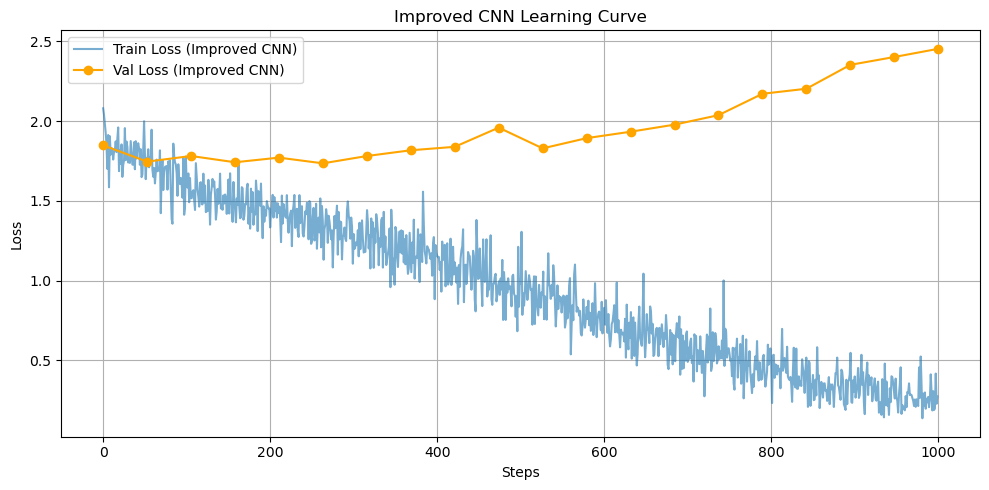

Classification Report (Improved CNN):
                                    precision    recall  f1-score   support

          Distal Convoluted Tubule       0.00      0.00      0.00        22
      Glomerular endothelial cells       0.17      0.11      0.13        19
    Interstitial endothelial cells       0.28      0.39      0.32        49
                        Leukocytes       0.11      0.08      0.09        25
                         Podocytes       0.11      0.04      0.06        23
          Proximal Tubule Segments       0.42      0.62      0.50       114
              Thick Ascending Limb       0.26      0.11      0.16        88

                          accuracy                           0.41       500
                         macro avg       0.24      0.25      0.23       500
                      weighted avg       0.36      0.41      0.37       500



In [36]:
# Q20
final_cnn_model, final_train_losses, final_val_losses = train_cnn(
    model=final_cnn_model,
    train_loader=train_loader_cnn,
    X_val_tensor=X_val_raw,
    y_val_tensor=y_val_raw
)

plt.figure(figsize=(10, 5))
plt.plot(final_train_losses, label="Train Loss (Improved CNN)", alpha=0.6)
plt.plot(np.linspace(0, len(final_train_losses), len(final_val_losses)), final_val_losses,
         label="Val Loss (Improved CNN)", color='orange', marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Improved CNN Learning Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

final_cnn_model.eval()
with torch.no_grad():
    val_logits_final = final_cnn_model(X_val_raw)
    preds_final = torch.argmax(val_logits_final, dim=1).numpy()

final_cnn_report = classification_report(
    y_val_raw.numpy(),
    preds_final,
    target_names=[label_map[i] for i in range(8)],
    zero_division=0
)

print(f'Classification Report (Improved CNN):\n{final_cnn_report}')

### Q20
#### **Comparison with Earlier CNNs:**

| Model             | Accuracy | Macro Precision | Macro Recall | Notes |
|------------------|----------|------------------|---------------|-------|
| **Q17: 3-layer**  | 35%      | 0.09             | 0.14          | Overfit to dominant class |
| **Q19: Deep CNN** | 32%      | 0.04             | 0.12          | Worse performance despite depth |
| **Q20: Improved** | **37%**  | **0.24**         | **0.23**      | Best class balance and recall |

---

#### **Conclusion:**
The improved CNN from Q20 achieved the highest overall **accuracy**, **macro precision**, and **macro recall** of all CNN models tested. It showed meaningful performance across multiple classes, including rare ones like *Glomerular endothelial cells* and *Interstitial endothelial cells*. This confirms that architectural regularization and optimizer tuning can significantly improve generalization — even when training on a small, imbalanced dataset.

Further improvements may come from:
- Data augmentation
- Class weighting in the loss function
- Training on a larger subset of the data

---
## Bonus Question

In [37]:
# Bonus

---